# Results S-ARIMA modelling 

In [2]:
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

In [3]:
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(8, 8))
plt.rc("font", size=13)

## Import training and test data of the UK smart meter data

In [4]:
import os
# print path
print(os.getcwd())

/Users/saschimi/Documents/github/ml4gd-project-group-3/arima


In [5]:
import pickle

filepath = "../uk-smart-meter-aggregated/"
filename = "df_agg.pkl"
# load pickle file
with open(filepath+filename, "rb") as f:
    df = pickle.load(f)
df.head()

,2,3,4,6,7,8,9,10,11,12,...,5535,5536,5537,5538,5541,5549,5550,5551,5557,5564
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_normalised = df.copy()
# Get the min and max of all rows
min = df_normalised.min(axis=1).min(axis=0)
max = df_normalised.max(axis=1).max(axis=0)
print("min: ", min, "max: ", max)
df_normalised = (df_normalised - min)/(max - min)

min:  0.0 max:  20.8689995


array([<Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>, <Axes: xlabel='DateTime'>,
       <Axes: xlabel='DateTime'>], dtype=object)

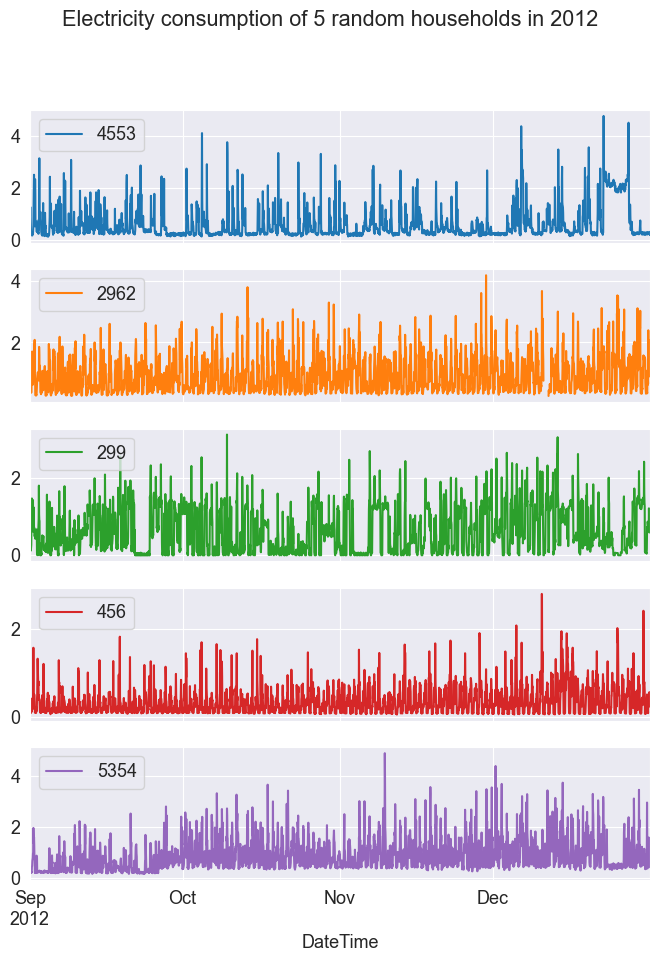

In [8]:
# Take five random households and create a time series plot of their electricity consumption
seed = 1997
np.random.seed(seed)
random_households = np.random.choice(df.columns, 5)
# Rows for DateTime = 2012-01-01 00:00:00 to 2012-12-31 23:00:00
df_range = df[(df.index >= "2012-09-01 00:00:00") & (df.index <= "2012-12-31 23:00:00")]
five_households = df_range[random_households]
five_households.plot(subplots=True, figsize=(8, 10), title="Electricity consumption of 5 random households in 2012")

In [9]:
print(five_households.describe())
print(five_households)

              4553         2962         299          456          5354
count  2928.000000  2905.000000  2928.000000  2928.000000  2928.000000
mean      0.571755     0.917800     0.614906     0.337636     0.833972
std       0.579718     0.576919     0.574584     0.312849     0.611521
min       0.113000     0.272000     0.000000     0.047000     0.144000
25%       0.231000     0.446000     0.074000     0.089000     0.411000
50%       0.334000     0.733000     0.436000     0.246000     0.600500
75%       0.656500     1.262000     1.147000     0.476250     1.123250
max       4.768000     4.173000     3.132000     2.792000     4.905000
                      4553   2962   299    456    5354
DateTime                                              
2012-09-01 00:00:00  0.902  1.116  0.259  0.085  0.199
2012-09-01 01:00:00  1.261  0.541  0.277  0.090  0.276
2012-09-01 02:00:00  1.243  0.473  0.174  0.098  0.231
2012-09-01 03:00:00  0.854  0.386  0.381  0.107  0.260
2012-09-01 04:00:00  0.404  0.4

## Split year into training and validation set
Use 1st of October to start the validation set.

In [68]:
# Split data into training and testing sets
train_start = np.argmin(five_households.index >= "2012-09-01 00:00:00")
train_end = np.argmin(five_households.index < "2012-11-30 00:00:00")
val_start = train_end + 1
train_end

2160

In [69]:
print("Sizes of training and validation sets:", train_end-train_start, len(five_households) - val_start)


Sizes of training and validation sets: 2160 767


## Create ARIMA model for the all households

In [70]:
# Should be imported
def impute_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """Fill missing values in the dataframe with the last known value of the timeseries. If the previous value is missing, fill with the next known value.

        Args:
        df (pd.DataFrame): 1D timeseries given as a pandas dataframe with the values in the field specified by value_axis.
    """
    # Find last value that is not NaN or zero before a value that is NaN or zero
    df.replace(0, np.nan, inplace=True)
    df.ffill(inplace=True, axis=0)
    df.bfill(inplace=True, axis=0)
    return df


## Analyse seasonality and select the seasonality that is more prominent -- show for first household only
The SARIMAX model can only handle single seasonality, this means, we need to select one period.

**Note**: We need to do data imputation because the MSTL seasonality detection cannot handle `NaN` values in the data.

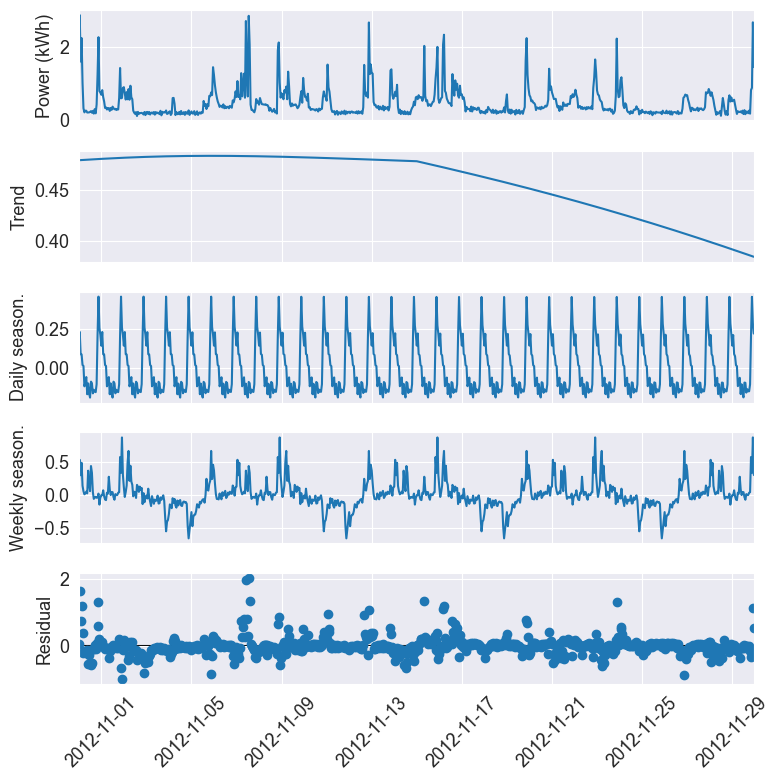

In [16]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import MSTL

mstl = MSTL(
    impute_missing_values(five_households.iloc[train_end-720:train_end, 0:1]),
    periods=[24, 24 * 7],  # The periods and windows must be the same length and will correspond to one another.
    windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
    iterate=3,
    stl_kwargs={
                "trend":1001, # Setting this large will force the trend to be smoother.
                "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
               }
)
res = mstl.fit()
fig = res.plot()
ax = fig.get_axes()
# Access subplots y labels
ax[0].set_title("")
ax[0].set_ylabel("Power (kWh)")
ax[1].set_ylabel("Trend")
ax[2].set_ylabel("Daily season.")
ax[3].set_ylabel("Weekly season.")
ax[4].set_ylabel("Residual")
ax[4].tick_params(axis='x', labelrotation=45)
fig.tight_layout()
fig.savefig("../figures/mstl_decomposition.pdf")

As we can see, the daily seasonality `24 h` follows a periodic pattern better than the weekly one. Hence, we select the daily seasonality for the model selection scheme in the next section.

## Fit SARIMAX models with single seasonality of 24h for all five households

In [17]:
first_household = impute_missing_values(five_households)
first_household.index.freq = "h"


/var/folders/9k/wg_0_d_15d3_g61jr75crzp80000gn/T/ipykernel_20498/1495129757.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(0, np.nan, inplace=True)
/var/folders/9k/wg_0_d_15d3_g61jr75crzp80000gn/T/ipykernel_20498/1495129757.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace=True, axis=0)
/var/folders/9k/wg_0_d_15d3_g61jr75crzp80000gn/T/ipykernel_20498/1495129757.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [71]:
from statsmodels.tsa.stattools import adfuller
for i,household in enumerate(five_households.columns):
    result = adfuller(five_households.iloc[train_start:train_end, i])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('')

ADF Statistic: -6.614775897574498
p-value: 6.246991083027021e-09

ADF Statistic: -7.170558017650102
p-value: 2.811793806647456e-10

ADF Statistic: -5.539723173248873
p-value: 1.7125346932402756e-06

ADF Statistic: -5.402141861566948
p-value: 3.3522937352393557e-06

ADF Statistic: -3.571769251004893
p-value: 0.006324249250224179



In [73]:
seasonal_order = (1, 0, 1, 24)
sarimaxes = []
for i in range(5):
    sarimax = sm.tsa.statespace.SARIMAX(five_households.iloc[train_start:train_end, i],
                                            trend="c",
                                            order=(1,0,1),
                                            seasonal_order=seasonal_order,
                                            enforce_invertibility=False,
                                            freq="h")
    sarimax_res = sarimax.fit(disp=False)
    sarimaxes.append(sarimax_res)

# forecast = sarimax_res.forecast(720)


In [74]:
predictions = []
for i in range(5):
    predictions.append(sarimaxes[i].predict(start=train_end-168, end=val_start+168))
predictions[0]

2012-11-23 00:00:00    0.997055
2012-11-23 01:00:00    0.795009
2012-11-23 02:00:00    0.605836
2012-11-23 03:00:00    0.613751
2012-11-23 04:00:00    0.543834
                         ...   
2012-12-06 21:00:00    0.757823
2012-12-06 22:00:00    0.725060
2012-12-06 23:00:00    0.642744
2012-12-07 00:00:00    0.587490
2012-12-07 01:00:00    0.591497
Freq: h, Name: predicted_mean, Length: 338, dtype: float64

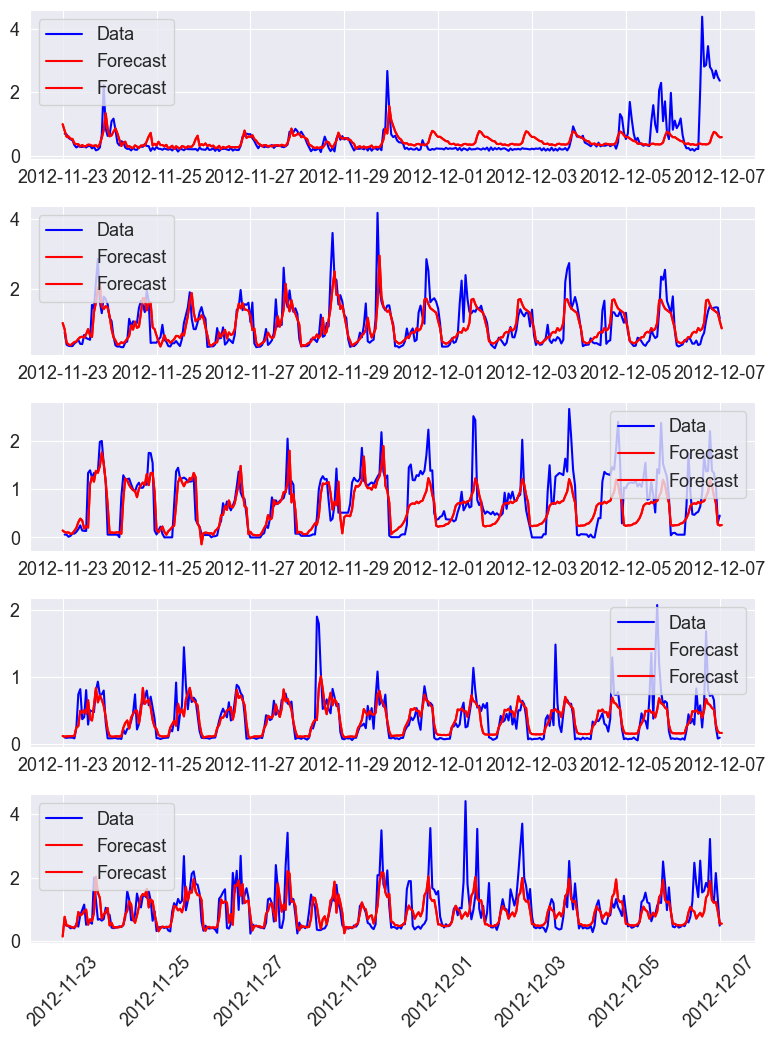

In [75]:
fig, axes = plt.subplots(5, 1, figsize=(8, 10))
# five_households.iloc[:-720, :].plot(ax= axes, subplots=True, figsize=(8, 10), title="Electricity consumption of 5 random households in 2012")
for i in range(5):
    axes[i].plot(five_households.iloc[val_start-168:val_start+168, i], label="Data", color="blue")
    axes[i].plot(predictions[i], label="Forecast", color="red")
    axes[i].plot(predictions[i], label="Forecast", color="red")
    axes[i].legend()
    # turn off the x-axis labels
    axes[i].set_xlabel("")
plt.tight_layout()
plt.tick_params(axis='x', labelrotation=45)

In [52]:
print(sarimax_res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               4880   No. Observations:                 6576
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood               -5127.849
Date:                            Mon, 17 Jun 2024   AIC                          10269.698
Time:                                    14:21:20   BIC                          10317.236
Sample:                                01-01-2012   HQIC                         10286.131
                                     - 09-30-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      2.485      0.013       0.000       0.001
ar.L1          1.2894      0.054   

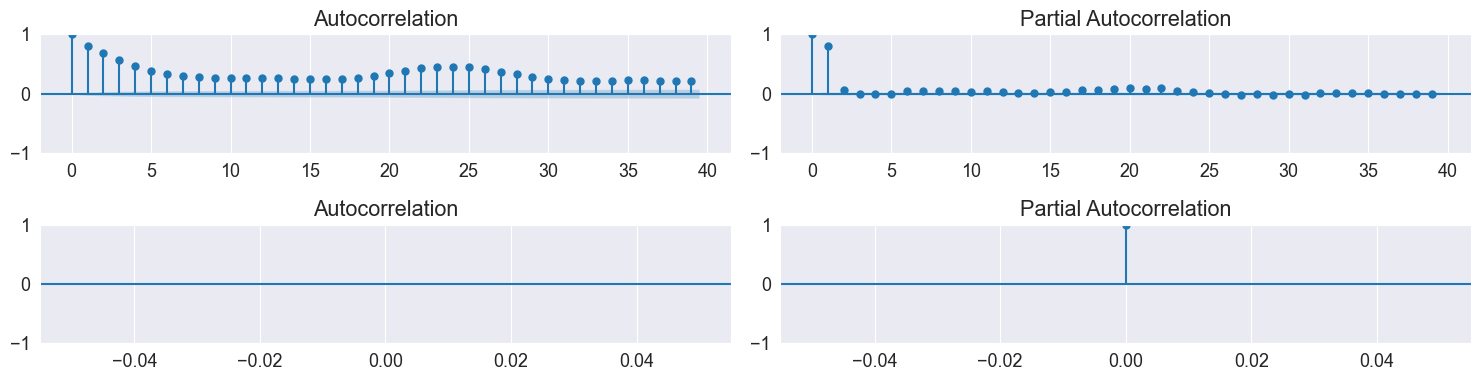

In [180]:
# Graph data
fig, axes = plt.subplots(2, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(first_household, ax=axes[0, 0])
fig = sm.graphics.tsa.plot_pacf(first_household, ax=axes[0, 1])

fig = sm.graphics.tsa.plot_acf(first_household.diff(), ax=axes[1,0])
fig = sm.graphics.tsa.plot_pacf(first_household.diff(), ax=axes[1, 1])
fig.tight_layout()

fig.savefig("../figures/acf_pacf.pdf")


In [62]:
import warnings

warnings.simplefilter('ignore')
def arima_aic(data, aic_full):
    """Train 3 times 3 ARIMA models with different p and q values and store the Akaike information criterion values in the dataframe passed as an argument.

    Args:
        data (_type_): Time series data to train the ARIMA models on.
        aic_full (_type_): DataFrame to store the AIC values of the ARIMA models.
    """
    # Based on prior analysis, we know that the seasonality is 24 hours
    seasonal_order = (1,0,1,24) # (Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)
    # Iterate over all ARMA(p,q) models with p,q in [0,6]
    for p in range(3):
        for q in range(3):
            # Baseline model does not have any AR or MA terms
            if p == 0 and q == 0:
                continue

            # Estimate the model with no missing datapoints
            mod = sm.tsa.statespace.SARIMAX(impute_missing_values(data),
                                            order=(p,0,q),
                                            seasonal_order=seasonal_order,
                                            enforce_invertibility=False)
            try:
                res = mod.fit(disp=False)
                aic_full.iloc[p,q] = res.aic
            except:
                aic_full.iloc[p,q] = np.nan


In [63]:
warnings.simplefilter('ignore')
aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
arima_aic(five_households.iloc[:train_end, 1:2], aic_full)
# Find the ARMA(p,q) model with the lowest AIC
print("Household", 1)
print(aic_full)
p_full, q_full = np.unravel_index(aic_full.values.argmin(), aic_full.shape)
print("Best ARMA(p,q) model:", p_full, q_full)

Household 1
             0            1            2    3    4    5
0     0.000000  1763.569263  1702.287202  0.0  0.0  0.0
1  1655.999958  1655.300960  1650.215682  0.0  0.0  0.0
2  1655.981956  1650.710153  1655.706845  0.0  0.0  0.0
3     0.000000     0.000000     0.000000  0.0  0.0  0.0
4     0.000000     0.000000     0.000000  0.0  0.0  0.0
5     0.000000     0.000000     0.000000  0.0  0.0  0.0
Best ARMA(p,q) model: 0 0


In [184]:
first_household = impute_missing_values(five_households.iloc[:train_end, 0:1]).copy(deep=True)
order = (1,1,1)
seasonal_order = (1, 1, 1, 24)
warnings.simplefilter('ignore')
sarimax = sm.tsa.statespace.SARIMAX(first_household,
                                    trend="t",
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_invertibility=False)
sarimax_res = sarimax.fit(disp=False)


In [185]:
print(sarimax_res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               4880   No. Observations:                 6576
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -6234.696
Date:                            Mon, 17 Jun 2024   AIC                          12481.391
Time:                                    16:56:13   BIC                          12522.116
Sample:                                01-01-2012   HQIC                         12495.471
                                     - 09-30-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       8.235e-09   4.18e-07      0.020      0.984    -8.1e-07    8.27e-07
ar.L1          0.4886      0.046   

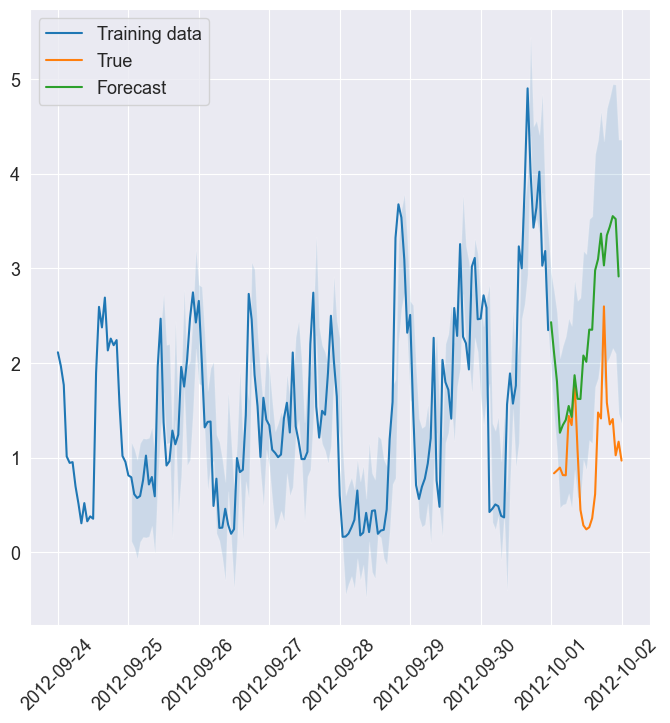

In [186]:
nforecast = 24
forecast = sarimax_res.forecast(nforecast)
predict = sarimax_res.get_prediction(end=sarimax.nobs + nforecast)
predict_ci = predict.conf_int(alpha=0.5)
fig, ax = plt.subplots(1, 1)
ax.plot(first_household[-nforecast*7:], label="Training data")
ax.plot(five_households.iloc[train_end+1:train_end+25, 0:1], label="True")
ax.plot(forecast, label="Forecast")
ax.fill_between(predict_ci.index[-nforecast*7:], predict_ci.iloc[-nforecast*7:, 0], predict_ci.iloc[-nforecast*7:, 1], alpha=0.15)
plt.legend()
ax.tick_params(axis='x', labelrotation=45)
fig.savefig(f"../figures/sarimax_{order}_{seasonal_order}.pdf")

In [95]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 24
predict = sarimax_res.get_prediction(end=sarimax.nobs + nforecast)
len(predict.predicted_mean)


6601

In [ ]:
p_full, q_full = np.unravel_index(aic_full.values.argmin(), aic_full.shape)
print("Best ARMA(p,q) model:", p_full, q_full)

In [123]:
# AIC values for all five households, looking into 6x6 different models
best_models = []
# Iterate over all five households
for i in range(5):
    aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
    arima_aic(five_households.iloc[3000:3000+train_set, i:i+1], aic_full)
    # Find the ARMA(p,q) model with the lowest AIC
    print("Household", i+1)
    print(aic_full)
    p_full, q_full = np.unravel_index(aic_full.values.argmin(), aic_full.shape)
    print("Best ARMA(p,q) model:", p_full, q_full)
    best_models.append((p_full, q_full))


Household 1
0       0.000000
1   -2621.841348
2   -2661.291938
3   -2664.062618
4   -2679.770406
5   -2687.388455
Name: 0, dtype: float64
Best ARMA(p,q) model: 2 4
Household 2
0    -3653.918667
1    -3653.427066
2    -3736.117686
3    48268.301567
4    41956.802893
5    31455.993007
Name: 1, dtype: float64
Best ARMA(p,q) model: 5 5
Household 3
0    125.480160
1    123.187811
2    121.002522
3    117.969301
4    115.189217
5    115.138981
Name: 2, dtype: float64
Best ARMA(p,q) model: 0 0
Household 4
0    10.0
1    12.0
2    14.0
3    16.0
4    18.0
5    20.0
Name: 3, dtype: float64
Best ARMA(p,q) model: 1 0
Household 5
0    12.0
1    14.0
2    16.0
3    18.0
4    20.0
5    22.0
Name: 4, dtype: float64
Best ARMA(p,q) model: 1 0


In [ ]:

# ARIMA model for household 1
st1 = STL(five_households[:train_set, 0], seasonal=1)
res = st1.fit()
fig = res.plot()


# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[1])


## Compute the ARIMA model that can handle missing data for a subset of the nodes

For each node we compare several ARIMA models based on the AIC, a information criterion to select models.
We then analyse if the majority of nodes would lead to the same ARIMA model (same order).

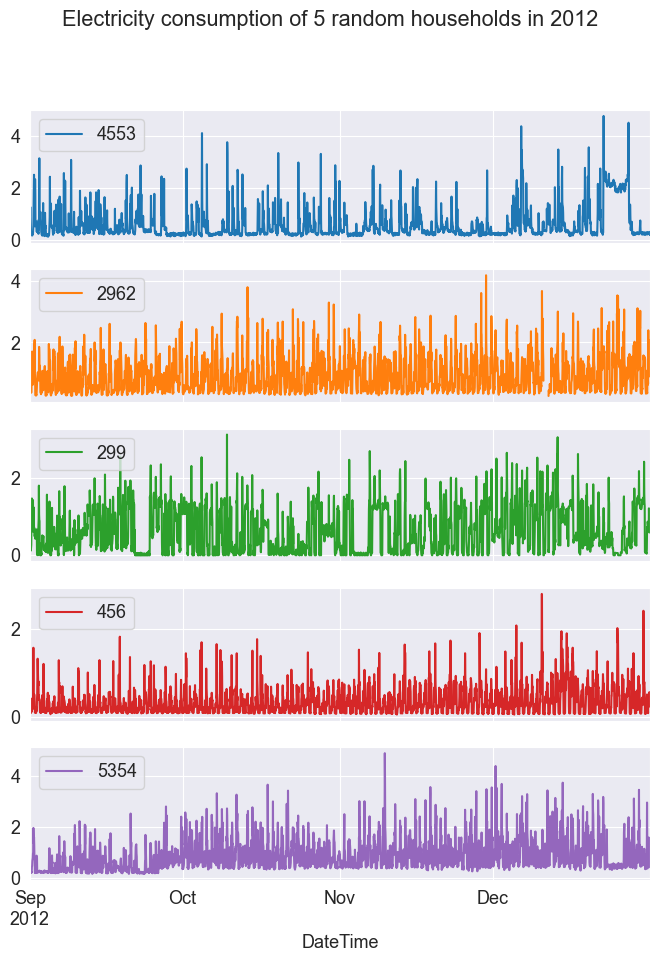

In [15]:
import pickle
import matplotlib.pyplot as plt

filepath = "../uk-smart-meter-aggregated/"
filename = "df_agg.pkl"
# load pickle file
with open(filepath+filename, "rb") as f:
    df = pickle.load(f)
# Set seed for reproducibility
seed = 1997
np.random.seed(seed)
random_households = np.random.choice(df.columns, 5)
# Rows for DateTime = 2012-01-01 00:00:00 to 2012-12-31 23:00:00
df_range = df[(df.index >= "2012-09-01 00:00:00") & (df.index <= "2012-12-31 23:00:00")]
five_households = df_range[random_households]
five_households.plot(subplots=True, figsize=(8, 10), title="Electricity consumption of 5 random households in 2012")
train_start = np.argmax(five_households.index >= "2012-09-01 00:00:00")
train_end = np.argmin(five_households.index < "2012-11-30 00:00:00")
val_start = train_end + 1
# Select node as
node = int(random_households[1])


In [21]:
five_households[node]

DateTime
2012-09-01 00:00:00    1.116
2012-09-01 01:00:00    0.541
2012-09-01 02:00:00    0.473
2012-09-01 03:00:00    0.386
2012-09-01 04:00:00    0.406
                       ...  
2012-12-31 19:00:00    2.068
2012-12-31 20:00:00    1.318
2012-12-31 21:00:00    1.216
2012-12-31 22:00:00    1.196
2012-12-31 23:00:00    1.117
Name: 2962, Length: 2928, dtype: float64

In [22]:
%load_ext autoreload
%autoreload 2
from arima import build_arima_model_for_node
# Build ARIMA model for node
sarimax_res = build_arima_model_for_node(five_households, node, impute_data=True)

predictions = []
# Plot seven last 7 days of fitted data and 7 days ahead (24 hours * 7 = 168)
predictions.append(sarimax_res.predict(start=train_end-168, end=val_start+168))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imputing missing values.
Create SARIMAX model.
Fitting SARIMAX model.


/Users/saschimi/Documents/github/ml4gd-project-group-3/arima/arima.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(0, np.nan, inplace=True)
/Users/saschimi/Documents/github/ml4gd-project-group-3/arima/arima.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace=True, axis=0)
/Users/saschimi/Documents/github/ml4gd-project-group-3/arima/arima.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bfill(inp

Done.


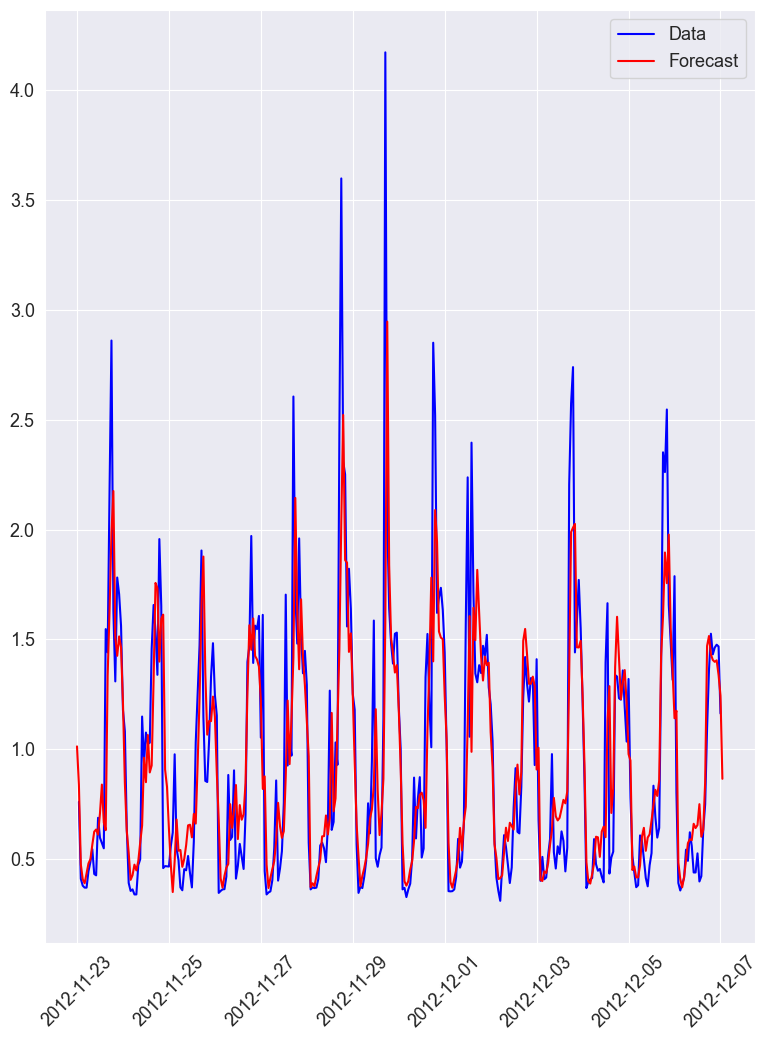

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(8, 10))
# five_households.iloc[:-720, :].plot(ax= axes, subplots=True, figsize=(8, 10), title="Electricity consumption of 5 random households in 2012")
for i in range(1):
    axes.plot(five_households[node].iloc[val_start-168:val_start+168], label="Data", color="blue")
    # axes[i].plot(predictions[i], label="Forecast", color="red")
    axes.plot(predictions[i], label="Forecast", color="red")
    axes.legend()
    # turn off the x-axis labels
    axes.set_xlabel("")
plt.tight_layout()
plt.tick_params(axis='x', labelrotation=45)
plt.show()

In [78]:
train_start

0